# Analyse data from computations on cluster

sampling ensembles with all the $^3 J$ scalar couplings

In [1]:
import os, pandas
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import jax.numpy as jnp

#### currently-defined functions

In [2]:
def save_dict_to_txt(my_dict, txt_path, sep : str=' '):
    """
    Save a dictionary as a txt file with column names given by indicization of dict keys.
    Each item value should be 0- or 1-dimensional (either int, float, np.ndarray or list),
    not 2-dimensional or more.
    """

    header = []
    values = []

    for key, arr in my_dict.items():
        if (type(arr) is int) or (type(arr) is float):
            header.append(key)
            values.append(arr)
        else:
            # assert ((type(arr) is np.ndarray) and (len(arr.shape) == 1)) or (type(arr) is list), 'error on element with key %s' % key
            # you could also have jax arrays, so manage as follows:

            try:
                l = len(arr.shape)
            except:
                l = 0
            assert (l == 1) or (type(arr) is list), 'error on element with key %s' % key
            
            # you should also check that each element in the list is 1-dimensional
            for i, val in enumerate(arr, 1):
                header.append(f"{key}_{i}")
                values.append(val)

    with open(txt_path, 'w') as f:
        f.write(sep.join(header) + '\n')
        f.write(sep.join(str(v) for v in values) + '\n')

    return

In [3]:
def detect_convergence(time_series, threshold_fact = 50., which_method = 1, if_plot = False):
    """
    There are several ways to detect convergence of a time series (beyond visual inspection),
    for example you can compute averages on time windows and then compare them.
    Here, `threshold_fact` is not required.

    Alternatively (`which_method = 2`), we can compute the variation of the cumulative averages
    and check where it goes under a threshold. This variation is equal to:

    $ \delta m(j) = m(j + 1) - m(j) = ... = 1/(j + 1) * (x_{j+1} - m(j))$

    where $m(j)$ is the cumulative average up to frame n. $j$.
    """

    time_series = np.asarray(time_series)

    if which_method == 1:
        std = np.std(time_series[-5000:])
        diffs = np.abs(time_series - time_series[-1])/std
        wh = np.argwhere(diffs < 7)

        b = ( len(wh)/len(diffs) > 0.99 )
        # this is to avoid sporadic deviations above the threshold will affect the convergence detection

        if b : position = 0
        else : position = wh[np.where(np.ediff1d(wh) != 1)][-1][0]

        if if_plot:
            plt.figure()
            plt.plot(diffs)
            plt.plot([0, len(diffs)], 7*np.ones(2), 'k')

        return position

    elif which_method == 2:
        cumulative_avg = np.cumsum(time_series) / np.arange(1, len(time_series) + 1)
        diff = np.ediff1d(cumulative_avg)

        my_max = np.max(diff)
        threshold = my_max/threshold_fact

        wh = np.argwhere(diff < threshold)
        b = ( wh[-1] == len(diff) - 1 )[0]

        if if_plot:
            plt.figure()
            plt.plot(diff)
            plt.plot([0, len(diff)], threshold*np.ones(2))
            plt.title('diff')

        if b :
            position = wh[np.where(np.ediff1d(wh) != 1)][-1][0]
            print('convergence found at %s' % position)
            return position
        else:
            print('convergence not detected')
            return None 


In [4]:
def my_mean(time_series, if_detect_convergence = False):
    if not if_detect_convergence:
        my_avs = np.mean(time_series, axis=0)
    else:
        my_avs = []

        for i in range(time_series.shape[1]):
            ind = detect_convergence(time_series[:, i])
            my_avs.append(np.mean(time_series[ind:, i]))

        my_avs = np.array(my_avs)
    return my_avs

In [5]:
def denormalize(values, normg_mean, normg_std, if_mean: bool=True):
    """
    denormalize mean (if if_mean) or standard deviation (if not if_mean)
    """
    if normg_mean is not None:
        denormalized_values = values*normg_std + normg_mean
    else:
        denormalized_values = values*normg_std
    return np.array(denormalized_values)

In [6]:
class MyData_parvalues:
    """
    from a pandas dataframe to a dictionary of class instances, without further memory required;
    in this way, you can add further properties to each class instance, beyond those in the pandas dataframe
    
    self.stride = row['stride'] → value is copied, no reference

    self._df = df + property → reference kept, reflects changes

    Defining new attributes as in the following lines will duplicate the data (twice memory will be required)
    indeed if I modify for example a value through MyData instance, the corresponding value
    in the original dataframe will not be modified
    
    for s in list(df.columns):
        setattr(self, s, df[s].loc[label])
    
    so, refer to it as reference-only: to do this we can define it as a method
    in addition, @property has specific advantages when you want an attribute-like interface with dynamic behavior:
    both dynamic computation (as method), still access it like an attribute e.g. obj.stride rather than obj.stride()
    the following lines correspond to what those containing make_getter do in each iteration
    
    @property
    def stride(self):
        return self.df.loc[self.label, 'stride']
    """
    def __init__(self, i, label, df):  # , traj, qs, ene):
        self.i = i
        self.label = label
        self.df = df  # this is just a reference (to the full dataframe), so no further memory is required

        for col in df.columns:  # also this is just a reference (see above)
            def make_getter(col):
                return property(lambda self: df.loc[self.label, col])
            
            setattr(self.__class__, col, make_getter(col))
        
        # # these are references (you can check by modifying just one element of that, it is modified also the original one)
        # self.traj = traj
        # self.n_steps_MC = traj.shape[0]
        # self.obs = qs[:, :28]
        # self.dkl = qs[:, 28]
        # if qs.shape[1] == 30: self.loss = qs[:, 29]
        # self.energy = ene

    def get_attributes(self):
        return [s for s in dir(self) if s[:2] != '__']


# class MyData(MyData_parvalues):
#         def __init__(self, mydata_parvalues : MyData_parvalues, traj, qs, ene):
#             super().__init__(**mydata_parvalues.__dict__)



class MyData(MyData_parvalues):
     def __init__(self, mydata_parvalues : MyData_parvalues, path):
        super().__init__(**mydata_parvalues.__dict__)

        # # these are references (you can check by modifying just one element of that, it is modified also the original one)
        # # you could also directly read them from input files
        # self.traj = traj
        # self.n_steps_MC = traj.shape[0]
        # self.obs = qs[:, :28]
        # self.dkl = qs[:, 28]
        # if qs.shape[1] == 30: self.loss = qs[:, 29]
        # self.energy = ene

        self.traj = np.load(path + 'Result_' + self.label + '/trajectory.npy', mmap_mode='r')
        self.n_steps_eff = self.traj.shape[0]

        qs = np.load(path + 'Result_' + self.label + '/quantities.npy', mmap_mode='r')

        self.obs = qs[:, :28]
        self.dkl = qs[:, 28]
        if qs.shape[1] == 30: self.loss = qs[:, 29]  # without non-informative prior
        self.energy = np.load(path + 'Result_' + self.label + '/energy.npy', mmap_mode='r')


## 1. load `data` about biomolecular systems
including both 'backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', since we will need to run `normalize_observables` in order to get `normg_mean` and `normg_std`
- `stride = 0` has been used for `load_data` on cluster computations (on top of that, several different strides)
- and `alpha = 10`

in the end we have:
- `data` object
- `n_frames` float value

In [7]:
# import local version from parent directory because otherwise it returns issues with print_references
import sys
sys.path.insert(0, '/home/ivang/Documenti/')
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '../../MDRefine')))

# import MDRefine

# print("I will use the MDRefine version installed at", MDRefine.__file__)

# import MDRefine_local
from MDRefine_local.MDRefine import load_data, normalize_observables, minimizer, unwrap_2dict, loss_function

# print('MDRefine version: ', MDRefine_local.__file__)  # issues with print references

In [8]:
# as indicated above
stride = 1
alpha = 10

In [9]:
infos = {'global': {
    'path_directory': '../DATA/',
    'system_names': ['AAAA'],  # , 'CAAU'],  # , 'CCCC', 'GACC', 'UUUU', 'UCAAUC'],
    'g_exp': ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J'],  # , 'NOEs'],# , ('uNOEs', '<')],
    'forward_qs': ['backbone1_gamma', 'backbone2_beta_epsilon', 'sugar'],
    # 'obs': ['NOEs'],#, 'uNOEs'],
    'forward_coeffs': 'original_fm_coeffs'}}


In [10]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs=None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        s + '_3J' : fm_coeffs[0]*forward_qs_cos[s]**2 + fm_coeffs[1]*forward_qs_cos[s] + fm_coeffs[2] for s in forward_qs_cos.keys()}
    
        # that is:
        # 'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        # 'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        # 'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [11]:
infos['global']['forward_model'] = forward_model_fun

In [12]:
infos['global']['names_ff_pars'] = ['sin alpha']  # , 'cos alpha']

def ff_correction(pars, f):
    # out = jnp.matmul(pars, (f[:, [0, 6]] + f[:, [1, 7]] + f[:, [2, 8]]).T)
    out = jnp.matmul(pars, (f[:, [0]] + f[:, [1]] + f[:, [2]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 10]] + f[:, [1, 11]] + f[:, [2, 12]] + f[:, [3, 13]] + f[:, [4, 14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
# infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [13]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
done


In [14]:
n_frames = data.mol['AAAA'].g['backbone1_gamma_3J'].shape

### 1a. compute mean and std values `normg_mean` and `normg_std`

to denormalize

done just once, no need to repeat again

In [15]:
if 'normalized_values' not in os.listdir():
    from MDRefine import normalize_observables

    my_folder = "normalized_values"

    if not os.path.exists(my_folder):
        os.mkdir(my_folder)

    strides = np.sort(np.unique(np.int64(whole_df_pars['stride'])))

    for stride in strides:
        print('stride: ', stride)

        data = load_data(infos, stride=stride)

        list_name_mol = list(data.mol.keys())

        for name_mol in list_name_mol:
            out = normalize_observables(data.mol[name_mol].gexp, data.mol[name_mol].g, weights=data.mol[name_mol].weights)

            # data.mol[name_mol].g = out[0]
            # data.mol[name_mol].gexp = out[1]
            # data.mol[name_mol].normg_mean = out[2]
            # data.mol[name_mol].normg_std = out[3]
            
            normg_mean = out[2]
            normg_std = out[3]

            my_tuple = (my_folder, name_mol, stride)
            # save_dict_to_txt(normg_mean, '%s/normg_mean_%s_%i' % my_tuple)
            # save_dict_to_txt(normg_std, '%s/normg_std_%s_%i' % my_tuple)

    !cp $my_folder remote_data/
    

since it is difficult to get access to `normg_g_*.pickle`, we can read them from the folder `normalized_data` (`norm_g_mean` and `norm_g_std` are the same for each `stride` and `name_sys` since they are computed directly by `load_data`)

## 2. read from remote folder
with `sshfs` (run the following cell just once)

in the end we have:
- `whole_df_pars` (saved as `csv`)
- `my_data` object



- this slows down Numpy reads `np.load`

```
%timeit np.load('../Results_sampling_ER_old/Result_' + df_pars.index[1] + '/trajectory.npy')

6.49 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
```

```
%timeit np.load(path + 'Result_' + df_pars.index[1] + '/trajectory.npy')

4.2 s ± 176 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

- to solve this issue you can load `.npy` files as read-only (`mmap_mode='r'`), or alternatively you could tune `sshfs` options

`sshfs -o cache=yes -o cache_timeout=600 -o compression=yes user@host:/remote/path /local/mount`

`%timeit np.load(path + 'Result_' + df_pars.index[1] + '/trajectory.npy', mmap_mode='r')`

- if `dir` does not exist make it, if it is empty fill it with sshfs (otherwise it is already updated)


In [15]:
%%bash

dir='remote_data'

if [ ! -d "$dir" ]; then
    mkdir "$dir"
fi

if [ -z "$(ls -A "$dir")" ]; then
    sshfs igilardo@frontend2.hpc.sissa.it:/home/igilardo/5_Jeffreys/Results_sampling_ER "$dir"
fi

### 2a. load and fix dataframe

if no new files have been computed, just read csv `whole_par_values`

In [17]:
# check:
b = 'whole_df_pars' in os.listdir()

print('is it present?', b)

if b:
    whole_df_pars = pandas.read_csv('whole_df_pars', index_col=0)
    print(whole_df_pars)

is it present? True
                            stride  alpha ER  normalize?  reduce?  dlambda  \
2025_05_15_17_52_31_914826  1000.0       0.5         1.0      0.0      0.2   
2025_05_15_17_52_36_670959  1000.0       0.5         1.0      0.0      0.2   
2025_05_15_18_40_13_500364  1000.0       0.5         1.0      0.0      0.2   
2025_05_15_18_41_14_071270   100.0       0.5         1.0      0.0      0.2   
2025_05_15_18_43_28_270804  1000.0       0.5         1.0      0.0      0.2   
...                            ...       ...         ...      ...      ...   
2025_07_09_08_14_06_806896  5000.0      10.0         1.0      0.0      0.2   
2025_07_09_08_16_07_813509  5000.0      10.0         1.0      0.0      0.2   
2025_07_09_08_20_57_209389  5000.0      10.0         1.0      0.0      0.2   
2025_07_09_08_22_06_765219  5000.0      10.0         1.0      0.0      0.2   
2025_07_09_08_28_28_769179  5000.0      10.0         1.0      0.0      0.2   

                             n_steps  av. a

In [24]:
path = 'remote_data/'  # '../Results_sampling_ER/'

file_list = list(np.sort(os.listdir(path)))
file_list.remove('normalized_values')

df_pars = []

for name in file_list[1:]:
    print(name)
    df_pars.append(pandas.read_csv(path + name + '/par_values', index_col=0))

df_pars = pandas.concat(df_pars, ignore_index=False).iloc[2:]



Result_2025_05_15_17_44_10_845681
Result_2025_05_15_17_44_12_194451
Result_2025_05_15_17_52_31_914826
Result_2025_05_15_17_52_36_670959
Result_2025_05_15_18_40_13_500364
Result_2025_05_15_18_41_14_071270
Result_2025_05_15_18_43_28_270804
Result_2025_05_15_18_43_51_327121
Result_2025_05_15_18_56_54_397682
Result_2025_05_15_20_06_29_437759
Result_2025_05_16_19_41_26_084836
Result_2025_05_16_19_43_41_404477
Result_2025_05_16_20_10_53_613148
Result_2025_05_16_20_32_51_324995
Result_2025_05_16_22_56_57_222520
Result_2025_05_17_01_59_56_237682
Result_2025_05_28_17_49_28_796056
Result_2025_05_28_18_04_06_983061
Result_2025_05_28_18_55_50_399304
Result_2025_05_29_08_49_27_427206
Result_2025_05_29_08_52_20_959036
Result_2025_05_29_17_01_51_621759
Result_2025_05_29_17_04_36_623758
Result_2025_05_29_17_55_06_717604
Result_2025_05_29_18_00_35_501063
Result_2025_05_29_18_04_57_737569
Result_2025_05_29_18_53_31_174209
Result_2025_05_29_19_39_19_914627
Result_2025_05_29_19_56_47_436295
Result_2025_05

In [25]:
n_obs = []

for ind in df_pars.index:
    print(ind)
    n_obs.append(np.load(path + 'Result_' + ind + '/trajectory.npy', mmap_mode='r').shape[1])

df_pars['n_obs'] = n_obs

2025_05_15_17_52_31_914826
2025_05_15_17_52_36_670959
2025_05_15_18_40_13_500364
2025_05_15_18_41_14_071270
2025_05_15_18_43_28_270804
2025_05_15_18_43_51_327121
2025_05_15_18_56_54_397682
2025_05_15_20_06_29_437759
2025_05_16_19_41_26_084836
2025_05_16_19_43_41_404477
2025_05_16_20_10_53_613148
2025_05_16_20_32_51_324995
2025_05_16_22_56_57_222520
2025_05_17_01_59_56_237682
2025_05_28_17_49_28_796056
2025_05_28_18_04_06_983061
2025_05_28_18_55_50_399304
2025_05_29_08_49_27_427206
2025_05_29_08_52_20_959036
2025_05_29_17_01_51_621759
2025_05_29_17_04_36_623758
2025_05_29_17_55_06_717604
2025_05_29_18_00_35_501063
2025_05_29_18_04_57_737569
2025_05_29_18_53_31_174209
2025_05_29_19_39_19_914627
2025_05_29_19_56_47_436295
2025_05_29_20_17_16_243363
2025_05_29_20_24_13_936256
2025_05_29_20_58_56_586573
2025_05_29_21_02_13_286943
2025_05_29_21_02_15_929011
2025_05_29_21_04_22_547431
2025_05_29_21_07_26_293204
2025_05_29_21_08_05_071910
2025_05_29_21_08_12_489403
2025_05_29_21_09_49_341230
2

In [26]:
new_names = ['alpha', 'if_normalize', 'if_reduce', 'if_Jeffreys', 'dx']
old_names = ['alpha ER', 'normalize?', 'reduce?', 'Jeffreys?', 'dlambda']

for i in range(len(new_names)):
    df_pars[old_names[i]] = df_pars[old_names[i]].fillna(df_pars[new_names[i]])
    df_pars = df_pars.drop(columns=[new_names[i]])

new_names = ['Jeffreys?']
old_names = ['which_measure']

for i in range(len(new_names)):
    df_pars[old_names[i]] = df_pars[old_names[i]].fillna(df_pars[new_names[i]])
    df_pars = df_pars.drop(columns=[new_names[i]])

whole_df_pars = df_pars
del df_pars

# old if_onebyone Nan values correspond to 0 (False), since I implemented this later
whole_df_pars.loc[np.isnan(whole_df_pars['if_onebyone']), 'if_onebyone'] = 0

whole_df_pars

,stride,alpha ER,normalize?,reduce?,dlambda,n_steps,av. acceptance,jobid,if_onebyone,time,which_measure,seed,n_obs
2025_05_15_17_52_31_914826,1000.0,0.5,1.0,0.0,0.2,1000.0,0.801,NaN,0.0,NaN,0.0,NaN,8
2025_05_15_17_52_36_670959,1000.0,0.5,1.0,0.0,0.2,1000.0,0.491,NaN,0.0,NaN,1.0,NaN,8
2025_05_15_18_40_13_500364,1000.0,0.5,1.0,0.0,0.2,100000.0,0.65162,NaN,0.0,NaN,1.0,NaN,8
2025_05_15_18_41_14_071270,100.0,0.5,1.0,0.0,0.2,100000.0,0.95413,NaN,0.0,NaN,0.0,NaN,8
2025_05_15_18_43_28_270804,1000.0,0.5,1.0,0.0,0.2,100000.0,0.96391,NaN,0.0,NaN,0.0,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025_07_09_08_14_06_806896,5000.0,10.0,1.0,0.0,0.2,500000.0,0.169877,16884908.0,0.0,39047.685236,0.0,1.0,28
2025_07_09_08_16_07_813509,5000.0,10.0,1.0,0.0,0.2,200000.0,0.03637,16884909.0,0.0,24858.715169,1.0,1.0,28
2025_07_09_08_20_57_209389,5000.0,10.0,1.0,0.0,0.2,500000.0,0.014696,16884910.0,0.0,41599.083922,3.0,1.0,28
2025_07_09_08_22_06_765219,5000.0,10.0,1.0,0.0,0.2,500000.0,0.014056,16884911.0,0.0,40622.122717,2.0,1.0,28


In [27]:
whole_df_pars.to_csv('whole_df_pars')

### 2b. select subset of the dataframe and load corresponding values

In [18]:
np.unique(whole_df_pars['n_steps'])

array([   1000.,  100000.,  200000.,  500000., 1000000.])

In [19]:
seed = 1.

# df_pars = df_pars[(df_pars['alpha ER'] == 10.) & (df_pars['reduce?'] == 0.) & (df_pars['n_obs'] == 28) & (df_pars['n_steps'] == int(1e5))]
df_pars = whole_df_pars.query(f'`alpha ER` == 10 and `reduce?` == 0 and n_obs == 28 and n_steps == {int(5e5)}'  \
    f'and if_onebyone == 0. and seed == {seed}')

df_pars = df_pars.sort_values(by='stride')

my_types = ['plain', 'J', 'Dir', 'av']

inds = {}
strides = {}

for i, s in enumerate(my_types):
    inds[s] = df_pars[df_pars['which_measure'] == float(i)].index
    strides[s] = df_pars[df_pars['which_measure'] == float(i)]['stride']

for s in strides.keys(): strides[s] = strides[s].astype(np.int64)

df_pars['time'] /= 3600

df_pars

,stride,alpha ER,normalize?,reduce?,dlambda,n_steps,av. acceptance,jobid,if_onebyone,time,which_measure,seed,n_obs
2025_07_08_18_04_48_344998,5.0,10.0,1.0,0.0,0.2,500000.0,0.059459,16884762.0,0.0,11.937816,2.0,1.0,28
2025_07_08_18_04_48_346556,5.0,10.0,1.0,0.0,0.2,500000.0,0.061971,16884763.0,0.0,11.992725,1.0,1.0,28
2025_07_08_19_25_18_778246,5.0,10.0,1.0,0.0,0.2,500000.0,0.023766,16884771.0,0.0,10.454162,3.0,1.0,28
2025_07_08_19_25_18_858189,5.0,10.0,1.0,0.0,0.2,500000.0,0.135350,16884770.0,0.0,11.653705,0.0,1.0,28
2025_07_08_18_30_18_815147,10.0,10.0,1.0,0.0,0.2,500000.0,0.062115,16884765.0,0.0,11.038101,1.0,1.0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025_07_08_17_07_37_825441,5000.0,10.0,1.0,0.0,0.2,500000.0,0.014696,16884150.0,0.0,3.267581,3.0,1.0,28
2025_07_08_16_38_49_779152,5000.0,10.0,1.0,0.0,0.2,500000.0,0.169877,16884146.0,0.0,2.942859,0.0,1.0,28
2025_07_08_16_34_46_346598,5000.0,10.0,1.0,0.0,0.2,500000.0,0.014056,16884143.0,0.0,3.414593,2.0,1.0,28
2025_07_09_08_20_57_209389,5000.0,10.0,1.0,0.0,0.2,500000.0,0.014696,16884910.0,0.0,11.555301,3.0,1.0,28


In [20]:
len(df_pars.index)

76

In [21]:
my_data = []

for i in range(len(list(df_pars.index))):
    my_data.append(MyData_parvalues(i, df_pars.iloc[i].name, df_pars))
    my_data[-1] = MyData(my_data[-1], 'remote_data/')

In [22]:
js = {}
js['uniform'] = [i for i in range(len(my_data)) if my_data[i].which_measure == 0]
js['jeffreys'] = [i for i in range(len(my_data)) if my_data[i].which_measure == 1]
js['dirichlet'] = [i for i in range(len(my_data)) if my_data[i].which_measure == 2]
js['average'] = [i for i in range(len(my_data)) if my_data[i].which_measure == 1]


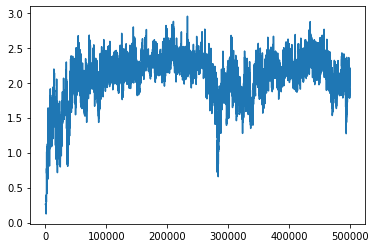

In [23]:
plt.plot(my_data[js['average'][-1]].dkl)

In [24]:
my_data[0].get_attributes()

['alpha ER',
 'av. acceptance',
 'df',
 'dkl',
 'dlambda',
 'energy',
 'get_attributes',
 'i',
 'if_onebyone',
 'jobid',
 'label',
 'loss',
 'n_obs',
 'n_steps',
 'n_steps_eff',
 'normalize?',
 'obs',
 'reduce?',
 'seed',
 'stride',
 'time',
 'traj',
 'which_measure']

working from remote (outside Sissa network, connecting via vpn) the download from `remote_data` seems to be very slow (expected time 40 min, 2 downloads per minute), so we could download the required folders (expected siz for the selected `inds`: 12 G); however, the required time to download each folder is more than the time needed for executing the cell below!

but... when limiting the array length [:int(1e5)] the reading is faster!?

In [25]:
my_types

['plain', 'J', 'Dir', 'av']

In [ ]:
path = 'remote_data/'  # '../Results_sampling_ER/'

trajs = {}
qs = {}
mus = {}
stds = {}


for s in my_types:

    trajs[s] = []
    qs[s] = []
    mus[s] = []
    stds[s] = []

    for i, ind in enumerate(inds[s]):
        trajs[s].append(np.load(path + 'Result_' + ind + '/trajectory.npy', mmap_mode='r')[:int(1e5)])
        qs[s].append(np.load(path + 'Result_' + ind + '/quantities.npy', mmap_mode='r')[:int(1e5)])

        # False (no detect_convergence) will ensure same n. of frames, provided same n. in input
        mus[s].append(my_mean(qs[s][-1], False))
        stds[s].append(my_mean(qs[s][-1], False))
        print(i, '/', len(inds[s]))

    mus[s] = np.array(mus[s])
    stds[s] = np.array(stds[s])


0 / 19
1 / 19
2 / 19
3 / 19
4 / 19
5 / 19
6 / 19
7 / 19
8 / 19
9 / 19
10 / 19
11 / 19
12 / 19
13 / 19
14 / 19
15 / 19
16 / 19
17 / 19
18 / 19
0 / 19
1 / 19
2 / 19
3 / 19
4 / 19
5 / 19
6 / 19
7 / 19
8 / 19
9 / 19
10 / 19
11 / 19
12 / 19
13 / 19
14 / 19
15 / 19
16 / 19
17 / 19
18 / 19
0 / 19
1 / 19
2 / 19
3 / 19
4 / 19
5 / 19
6 / 19
7 / 19
8 / 19
9 / 19
10 / 19
11 / 19
12 / 19
13 / 19
14 / 19
15 / 19
16 / 19
17 / 19
18 / 19
0 / 19
1 / 19
2 / 19
3 / 19
4 / 19
5 / 19
6 / 19
7 / 19
8 / 19
9 / 19
10 / 19
11 / 19
12 / 19
13 / 19
14 / 19
15 / 19
16 / 19
17 / 19
18 / 19


## 3. analyze and plot output values

starting from `data`, `my_data` objects

0.44997251504817926
0.44997251504817926
0.45846811252713776
0.45846811252713776
0.462738353171544
0.462738353171544
0.46382608227163563
0.46382608227163563
0.4873125840697166
0.4873125840697166
0.4676320040316514
0.4676320040316514
0.496841751907777
0.496841751907777
0.4592695972137398
0.4592695972137398
0.6158067141606113
0.6158067141606113
0.8985884361471302
1.139341967441963
0.7804414768454223
0.7804414768454223
0.7577338011710513
0.7468409779049281
1.0366276136598014
1.038389907106812
1.251199426867295
1.2885258735346137
1.3012105694304326
1.3277900466151475
0.8972778785218616
0.8972778785218616
1.0994066519903745
1.1312985716856563
1.0388343093515149
1.1113053448877712
1.0388343093515149
1.1113053448877712


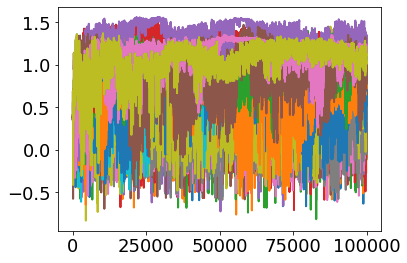

In [ ]:
s = 'plain'

for i in range(len(inds[s])):

    time_series = qs[s][i][:, 8]

    plt.plot(time_series)

    print(np.mean(time_series))

    ind = detect_convergence(time_series)
    print(np.mean(time_series[ind:]))

1.0388343093515149
32386
1.1113053448877712


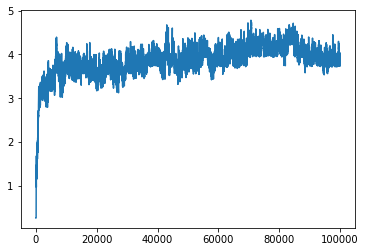

In [ ]:
plt.plot(qs['plain'][-1][:, 28])

time_series = qs['plain'][-1][:, 8]

print(np.mean(time_series, axis=0))

ind = detect_convergence(time_series)
print(ind)

print(np.mean(time_series[ind:]))

In [ ]:
if 'if_one_by_one' in df_pars.keys():  # df_pars['if_one_by_one'].iloc[0]:
    mus_onebyone = mus
    stds_onebyone = stds
    strides_onebyone = strides

denormalize and plot also experimental and average values

In [ ]:
path = 'normalized_values/normg_%s_AAAA_'

normg_mean = {}
normg_std = {}

for stride in strides['plain']:
    normg_mean[stride] = np.array(pandas.read_csv((path % 'mean') + str(stride), sep=' '))[0]
    normg_std[stride] = np.array(pandas.read_csv((path % 'std') + str(stride), sep=' '))[0]

In [ ]:
if mus[s][i].shape[0] == 30 : j = -2
elif mus[s][i].shape[0] == 29 : j = -1

for s in mus.keys():
    for i in range(len(mus[s])):
        # up to -1, since the last is the relative entropy
        stride = strides[s].iloc[i]
        mus[s][i][:-2] = denormalize(mus[s][i][:-2], normg_mean[stride], normg_std[stride])
        stds[s][i][:-2] = denormalize(stds[s][i][:-2], None, normg_std[stride])


In [ ]:
my_gexp = data.mol['AAAA'].gexp

g_exps = np.concatenate([my_gexp[s][:, 0] for s in my_gexp.keys()])
err_exps = np.concatenate([my_gexp[s][:, 1] for s in my_gexp.keys()])

In [ ]:
strides['plain'][0]

5

(5, 70002)
(10, 100000)
(15, 100000)
(20, 100000)
(35, 100000)
(50, 100000)
(75, 100000)
(100, 100000)
(150, 100000)
(200, 100000)
(350, 100000)
(500, 100000)
(750, 100000)
(1000, 100000)
(1500, 100000)
(2000, 100000)
(3500, 100000)
(5000, 100000)
(5000, 100000)


ValueError: x and y must have same first dimension, but have shapes (19,) and (18,)

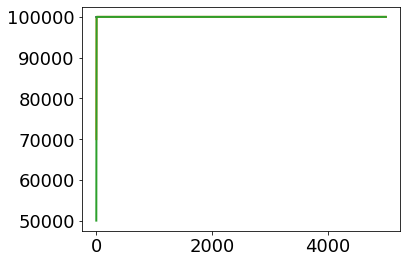

In [ ]:
my_type = 'J'

for i in range(len(qs[my_type])):
    print((strides[my_type][i], qs[my_type][i].shape[0]))

for my_type in my_types:
    steps = [qs[my_type][i].shape[0] for i in range(len(qs[my_type]))]
    plt.plot(strides[my_type], steps)
plt.xscale('log')

!! mismatch between n. of Monte Carlo steps required (as in `df_pars[n_steps]`) and the real ones, as in `qs['plain'][0].shape[0]`

- with `'plain'` is almost the same over different strides, but with `J`?

so, let's stop at 1e5 steps, almost equal for all

In [ ]:
i = 0

qs['plain'][i].shape[0]*strides['plain'][i]



1700010

In [ ]:
n_frames = data.mol['AAAA'].g['backbone1_gamma_3J'].shape[0]

print(n_frames)

n_frames/a_max

1017000


143.9961725437337

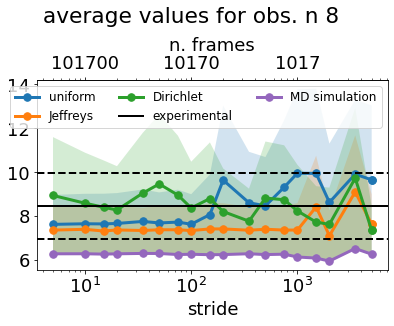

In [ ]:
my_types = ['plain', 'J', 'Dir', 'av']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
labels = ['uniform', 'Jeffreys', 'Dirichlet', 'average']

# focus on observable n. 8 !!
n_obs = 8  # for n_obs in [8]:  # range(20):

fig, ax = plt.subplots(figsize=(6, 5))

for i, s in enumerate(my_types[:-1]):
    ax.plot(strides[s], mus[s][:, n_obs], '.-', label=labels[i], c=colors[i], linewidth=3, markersize=15)
    # plt.errorbar(strides[s], mus[s][:, n_obs], yerr=stds[s][j, n_obs], c=colors[i], capsize=5)
    y_low = mus[s][:, n_obs] - stds[s][:, n_obs]
    y_up = mus[s][:, n_obs] + stds[s][:, n_obs]
    ax.fill_between(strides[s], y_low, y_up, mus[s][:, n_obs] + stds[s][:, n_obs], alpha=0.2)
    # plt.plot(strides[s], y_low, '--', c=colors[i])
    # plt.plot(strides[s], y_up, '--', c=colors[i])

ax.set_xscale('log')
xlim = plt.xlim()

ax.plot(xlim, g_exps[n_obs]*np.ones(2), '-k', label='experimental')
ax.plot(xlim, (g_exps[n_obs] + err_exps[n_obs])*np.ones(2), '--k')
ax.plot(xlim, (g_exps[n_obs] - err_exps[n_obs])*np.ones(2), '--k')

avgs = np.array([(stride, normg_mean[stride][n_obs]) for stride in np.unique(strides['plain'])])
ax.plot(avgs[:, 0], avgs[:, 1], '.-', label='MD simulation', c=colors[4], linewidth=3, markersize=15)

ax.set_xlim(xlim)
ax.legend(ncol=3, fontsize=12)
fig.suptitle('average values for obs. n %i' % n_obs, y=.92)
ax.set_xlabel('stride')

# Add top x-axis with same ticks
secax = ax.secondary_xaxis('top', functions=(lambda x: x, lambda x: x))
secax.set_xlabel("n. frames")

# xtick_labels = np.array([float(tick.get_text()) for tick in ax.get_xticklabels()[1:-1]])
xtick_labels = [10, 100, 1000]

secax.set_xticks(ax.get_xticks(), ['%i' % i for i in n_frames//ax.get_xticks()])

plt.tight_layout()
# plt.show()

# plt.savefig('Manuscript_images/final_comparison_obs_n8.pdf', format='pdf', bbox_inches='tight')


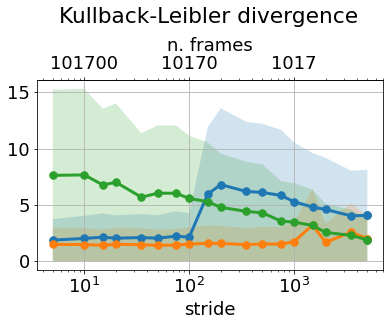

In [ ]:
# focus on dkl

my_types = ['plain', 'J', 'Dir', 'av']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

fig, ax = plt.subplots(figsize=(6, 5))

n_obs = mus[s].shape[1] - 2  # last value

for i, s in enumerate(my_types[:-1]):
    ax.plot(strides[s], mus[s][:, n_obs], '.-', label=s, c=colors[i], linewidth=3, markersize=15)
    # plt.errorbar(strides[s], mus[s][:, n_obs], yerr=stds[s][j, n_obs], c=colors[i], capsize=5)
    y_low = mus[s][:, n_obs] - stds[s][:, n_obs]
    y_up = mus[s][:, n_obs] + stds[s][:, n_obs]
    ax.fill_between(strides[s], y_low, y_up, mus[s][:, n_obs] + stds[s][:, n_obs], alpha=0.2)
    # plt.plot(strides[s], y_low, '--', c=colors[i])
    # plt.plot(strides[s], y_up, '--', c=colors[i])

ax.set_xscale('log')
xlim = plt.xlim()

ax.set_xlim(xlim)
ax.grid()
fig.suptitle('Kullback-Leibler divergence', x=.55, y=.92)
ax.set_xlabel('stride')

# Add top x-axis with same ticks
secax = ax.secondary_xaxis('top', functions=(lambda x: x, lambda x: x))
secax.set_xlabel("n. frames")

# xtick_labels = np.array([float(tick.get_text()) for tick in ax.get_xticklabels()[1:-1]])
xtick_labels = [10, 100, 1000]
secax.set_xticks(ax.get_xticks(), ['%i' % i for i in n_frames//ax.get_xticks()])

plt.tight_layout()
# plt.show()

# plt.savefig('Manuscript_images/final_comparison_dkl.pdf', format='pdf', bbox_inches='tight')


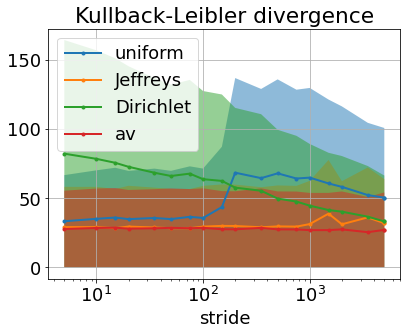

In [ ]:
plt.figure(figsize=(6, 5))

n_obs = mus[s].shape[1] - 1  # last value
labels = ['uniform', 'Jeffreys', 'Dirichlet', 'av']
my_types = ['plain', 'J', 'Dir', 'av']

for i, s in enumerate(my_types):
    plt.plot(strides[s], mus[s][:, n_obs], '.-', label=labels[i], c=colors[i])
    # plt.errorbar(strides[s], mus[s][:, n_obs], yerr=stds[s][:, n_obs], c=colors[i], capsize=5)
    plt.fill_between(strides[s], mus[s][:, n_obs] - stds[s][:, n_obs], mus[s][:, n_obs] + stds[s][:, n_obs], alpha=0.5)

plt.xscale('log')
plt.title('Kullback-Leibler divergence')
plt.grid()
plt.xlabel('stride')
plt.legend()

# Add top x-axis with same ticks
secax = ax.secondary_xaxis('top', functions=(lambda x: x, lambda x: x))
secax.set_xlabel("n. frames")

# xtick_labels = np.array([float(tick.get_text()) for tick in ax.get_xticklabels()[1:-1]])
xtick_labels = [10, 100, 1000]
print(xtick_labels)

# # secax.set_xticks(secax.get_xticks(), xtick_labels**2)
secax.set_xticks(ax.get_xticks(), ['%i' % i for i in n_frames//ax.get_xticks()])


plt.tight_layout()
plt.show()

ax.grid()
secax.grid()

# plt.savefig('Manuscript_images/ex2_all_dkl_seed%i.pdf' % seed, format='pdf', bbox_inches='tight')

['plain', 'J', 'Dir', 'av'] ['uniform', 'Jeffreys', 'Dirichlet', 'average'] match?


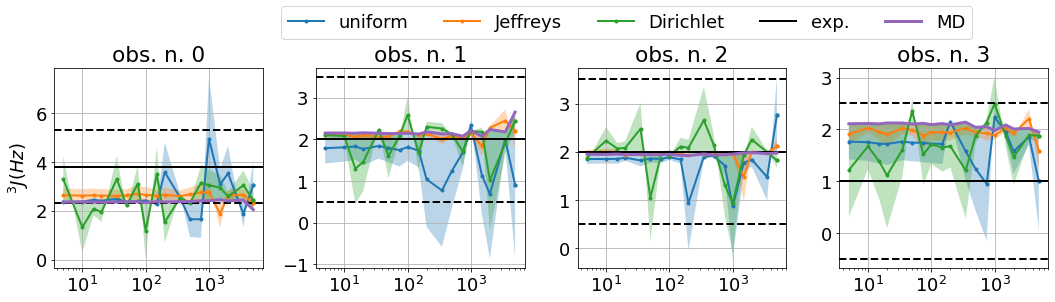

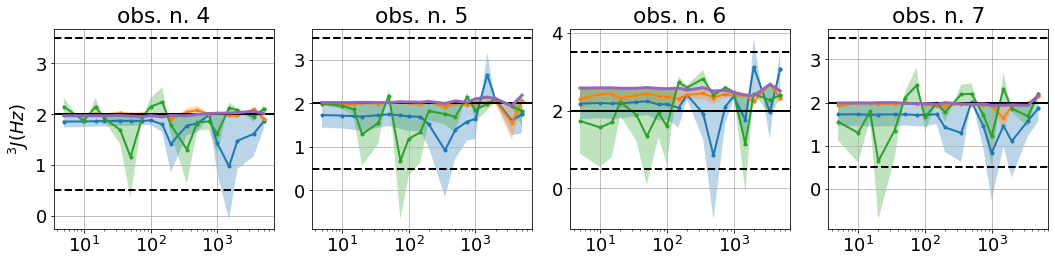

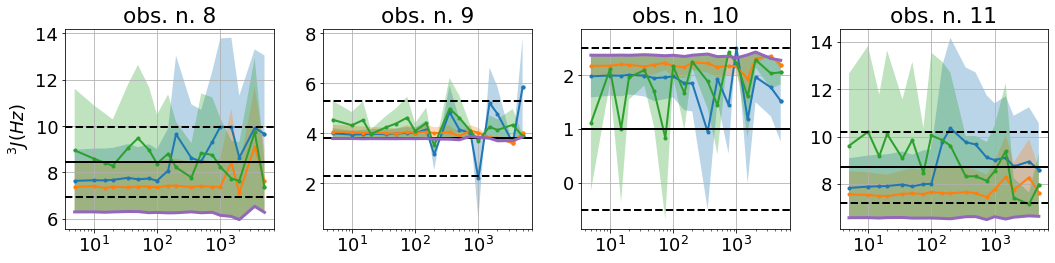

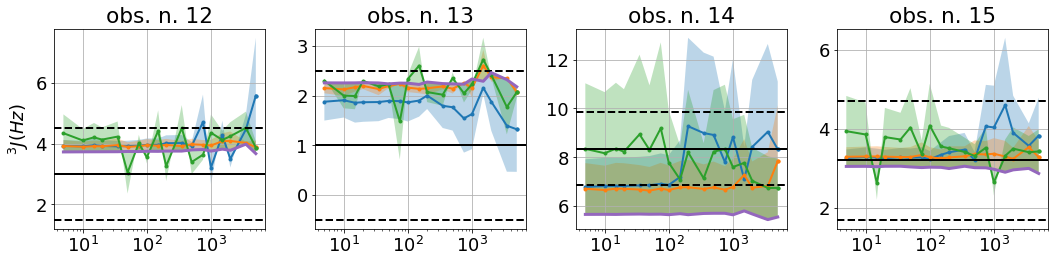

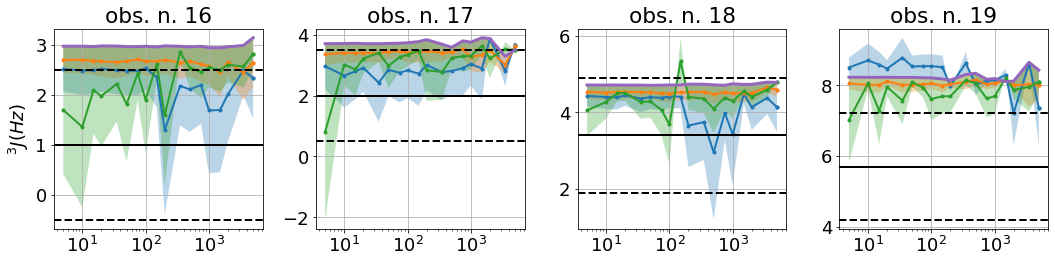

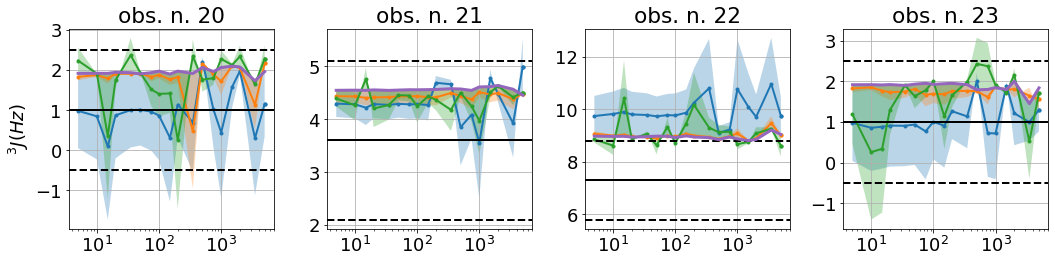

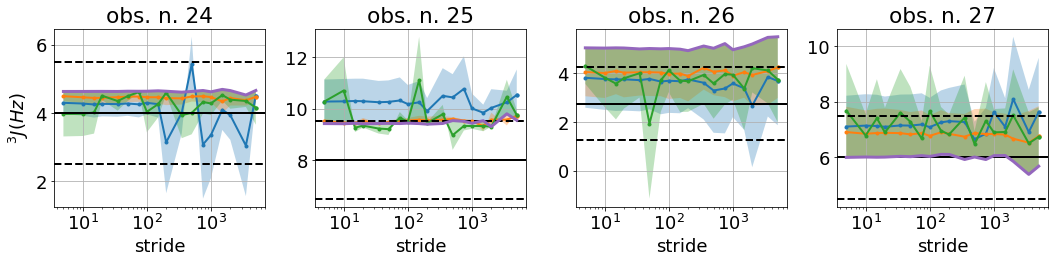

In [ ]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 18
plt.rcParams.update({'figure.autolayout': True})

labels = ['uniform', 'Jeffreys', 'Dirichlet', 'average']
print(my_types, labels, 'match?')

tot_n_obs = mus['plain'].shape[1] - 2  # -1 because the last two are the relative entropy and loss
n_cols = 4  # how many columns for each row

n_row = 0

for n_obs in range(tot_n_obs):

    n_col = np.mod(n_obs, n_cols)

    if n_col == 0: fig, axs = plt.subplots(1, n_cols, figsize=(15, 4))# , constrained_layout=True)

    for i, s in enumerate(my_types[:-1]):
        axs[n_col].plot(strides[s], mus[s][:, n_obs], '.-', label=labels[i], c=colors[i])
        # axs[n_col].errorbar(strides[s], mus[s][:, n_obs], yerr=stds[s][:, n_obs], c=colors[i], capsize=5)
        axs[n_col].fill_between(strides[s], mus[s][:, n_obs] - stds[s][:, n_obs], mus[s][:, n_obs] + stds[s][:, n_obs], alpha=0.3)

    axs[n_col].set_xscale('log')
    xlim = axs[n_col].get_xlim()

    axs[n_col].plot(xlim, g_exps[n_obs]*np.ones(2), '-k', label='exp.')
    axs[n_col].plot(xlim, (g_exps[n_obs] + err_exps[n_obs])*np.ones(2), '--k')
    axs[n_col].plot(xlim, (g_exps[n_obs] - err_exps[n_obs])*np.ones(2), '--k')

    avgs = np.array([(stride, normg_mean[stride][n_obs]) for stride in np.unique(strides['plain'])])
    axs[n_col].plot(avgs[:, 0], avgs[:, 1], label='MD', c=colors[4], linewidth=3)

    axs[n_col].set_title('obs. n. %i' % n_obs)
    axs[n_col].set_xlim(xlim)
    axs[n_col].grid()

    if n_col == 0: axs[n_col].set_ylabel(r'$^3 J (Hz)$')
    if n_row == (tot_n_obs//n_cols - 1): axs[n_col].set_xlabel('stride')
    
    if n_row == 0 and n_col == 0: fig.legend(ncol=6, bbox_to_anchor=(0.92, 1.1))

    # if np.mod(n_obs, n_cols) == 3: plt.savefig('Manuscript_images/final_comparison_%i.pdf' % n_row, format='pdf', bbox_inches='tight')

    if n_col == (n_cols - 1): n_row += 1

In [ ]:
print(np.unique(strides['plain']))

[   5   10   15   20   35   50   75  100  150  200  350  500  750 1000
 1500 2000 3500 5000]


Text(0.5, 1.0, 'obs. n. 8')

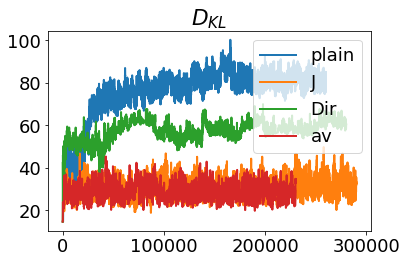

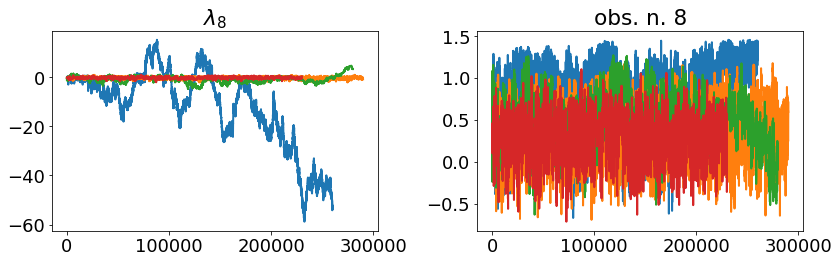

In [ ]:
stride = 350

for s in strides.keys():
    i = np.argwhere(np.array(strides[s]) == stride)[0][0]
    plt.plot(qs[s][i][:, -1], label=s)
plt.legend()
plt.title(r'$D_{KL}$')

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
j = 8
for s in strides.keys():
    i = np.argwhere(np.array(strides[s]) == stride)[0][0]
    axs[0].plot(trajs[s][i][:, j])
    axs[1].plot(qs[s][i][:, j])

axs[0].set_title('$\lambda_%i$' % j)
axs[1].set_title('obs. n. %i' % j)




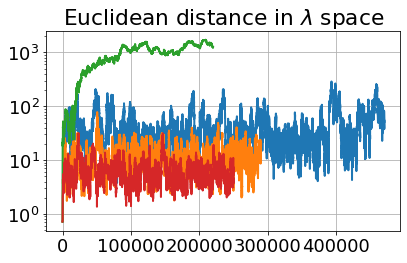

In [ ]:
plt.figure()

stride = 75

for s in strides.keys():
    i = np.argwhere(np.array(strides[s]) == stride)[0][0]
    euclid_dist = np.sum(trajs[s][i]**2, axis=1)
    plt.plot(euclid_dist, label=s)

plt.title('Euclidean distance in $\lambda$ space')
plt.yscale('log')
plt.grid()

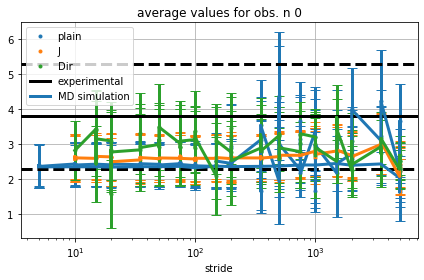

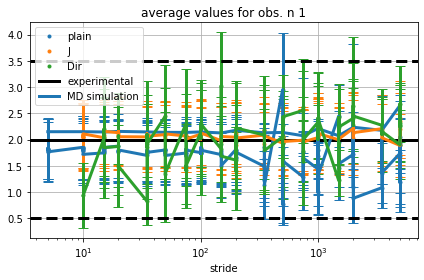

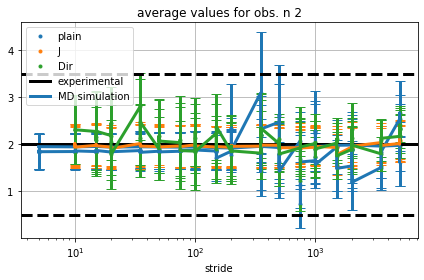

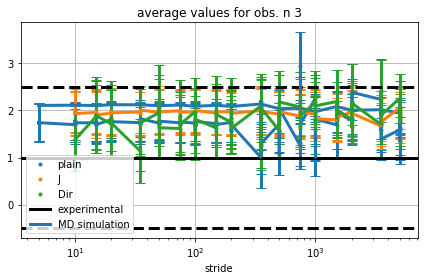

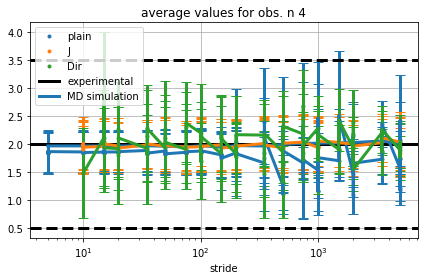

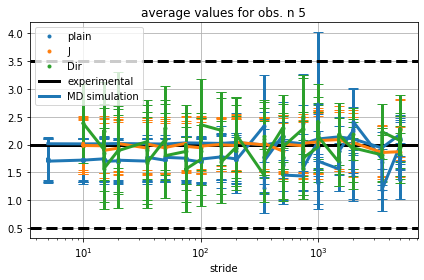

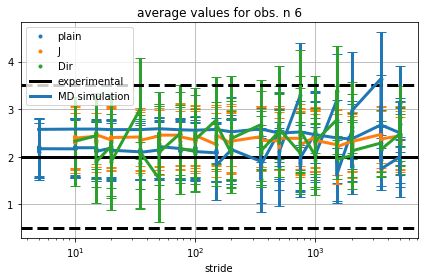

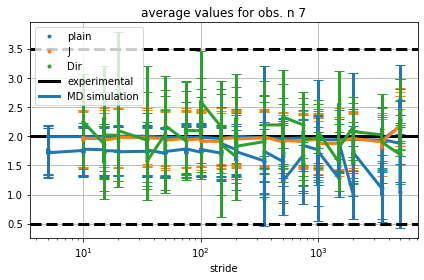

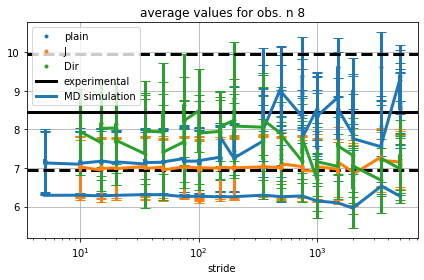

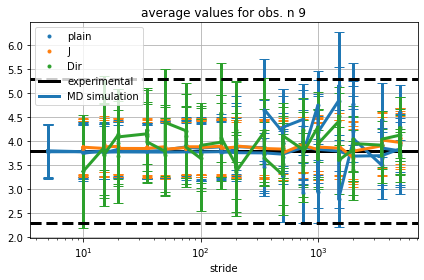

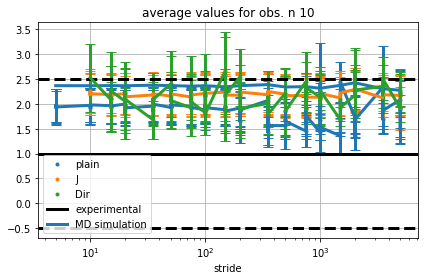

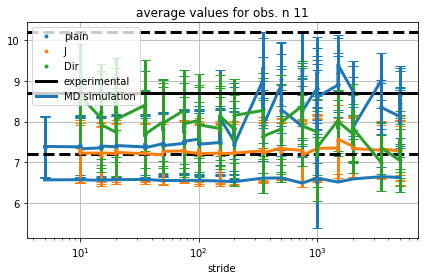

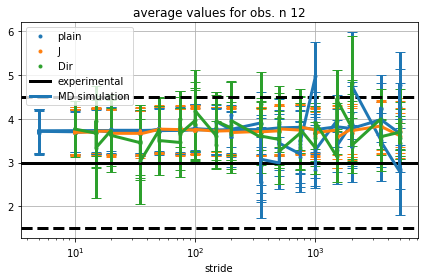

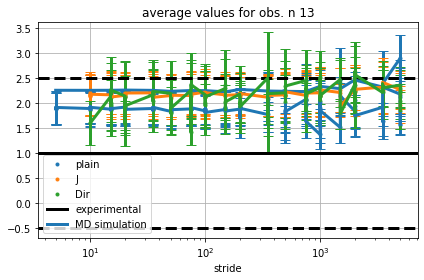

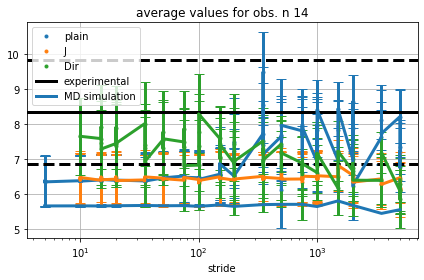

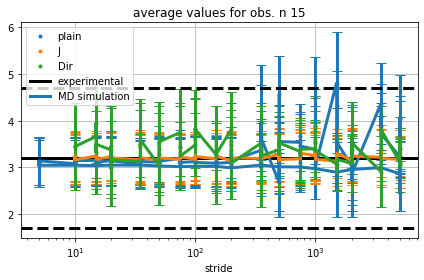

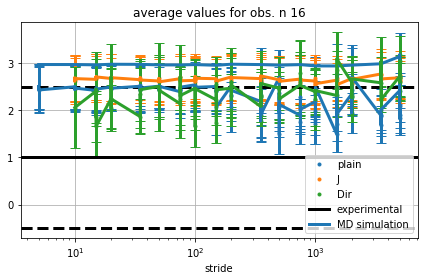

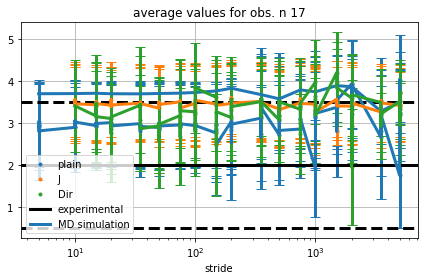

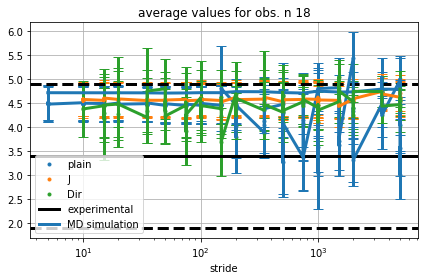

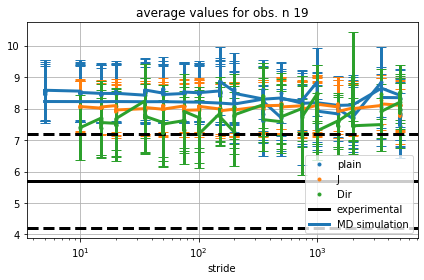

In [ ]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

# my_types = ['plain', 'J']

for n_obs in range(20):

    plt.figure()

    # focus on observable n. 8 !!
    for i, s in enumerate(my_types):
        plt.plot(strides[s], mus[s][:, n_obs], '.', label=s, c=colors[i])
        plt.errorbar(strides[s], mus[s][:, n_obs], yerr=stds[s][:, n_obs], c=colors[i], capsize=5)

    plt.xscale('log')
    xlim = plt.xlim()

    plt.plot(xlim, g_exps[n_obs]*np.ones(2), '-k', label='experimental')
    plt.plot(xlim, (g_exps[n_obs] + err_exps[n_obs])*np.ones(2), '--k')
    plt.plot(xlim, (g_exps[n_obs] - err_exps[n_obs])*np.ones(2), '--k')

    avgs = np.array([(stride, normg_mean[stride][n_obs]) for stride in np.unique(strides['plain'])])
    plt.plot(avgs[:, 0], avgs[:, 1], label='MD simulation')

    plt.xlim(xlim)
    plt.grid()
    plt.title('average values for obs. n %i' % n_obs)
    plt.xlabel('stride')
    plt.legend()